# AutoLowRankMultivariateNormal parametrizations

This notebook aims to validate parametrizations of Pyro's [AutoLowRankMultivariateNormal](http://docs.pyro.ai/en/stable/infer.autoguide.html#autolowrankmultivariatenormal) guide, in the context of https://github.com/pyro-ppl/pyro/pull/2127

In [1]:
# These are needed so the git commands below take immediate effect.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoLowRankMultivariateNormal
from pyro.optim import ClippedAdam
from matplotlib import pyplot

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%config InlineBackend.rc = {'figure.facecolor': (1, 1, 1, 1)}

Let's test with a generative model with a wide range of data scales (exponentially distributed), and with a low rank structure. We'll later fit this with a guide with even lower rank.

In [3]:
class Model:
    def __init__(self, dim, rank):
        self.dim = dim
        self.rank = rank
        self.loc1 = dist.Laplace(0, 1).sample((dim,))
        self.scale1 = dist.Exponential(1).sample((dim,))
        self.loc2 = dist.Laplace(0, 1).sample((rank,))
        self.scale2 = dist.Exponential(1).sample((rank,))
        self.mat = dist.Normal(0, 1).sample((dim, rank))

    def __call__(self):
        z = pyro.sample("z",
                        dist.Normal(self.loc1, self.scale1)
                            .expand([self.dim]).to_event(1))
        pyro.sample("x",
                    dist.Normal(self.loc2, self.scale2)
                        .expand([self.rank]).to_event(1),
                    obs=z @ self.mat)

In [4]:
def train(dim, rank):
    pyro.clear_param_store()
    pyro.set_rng_seed(123456789)
    model = Model(dim, 2 * rank)
    guide = AutoLowRankMultivariateNormal(model, rank=rank, init_scale=0.01)
    optim = ClippedAdam({"lr": 0.01})
    elbo = Trace_ELBO()
    svi = SVI(model, guide, optim, elbo)
    losses = []
    for step in range(1000):
        loss = svi.step() / dim
        losses.append(loss)
        if step % 100 == 0:
            print("step {: >4} loss = {:0.8g}".format(step, loss))
    return losses

In [5]:
results = {}

In [6]:
!(cd ~/pyro ; git checkout dev)

Switched to branch 'dev'
Your branch is up-to-date with 'origin/dev'.


In [7]:
results["dev-10-3"] = train(10, 3)
results["dev-100-10"] = train(100, 10)
results["dev-1000-30"] = train(1000, 30)
results["dev-10000-100"] = train(10000, 100)

step    0 loss = 13.780161
step  100 loss = 7.5164486
step  200 loss = 3.2791649
step  300 loss = 3.7953847
step  400 loss = 3.4260708
step  500 loss = 2.5331796
step  600 loss = 3.4079221
step  700 loss = 2.5619433
step  800 loss = 6.5012927
step  900 loss = 2.7550673
step    0 loss = 254.39218
step  100 loss = 80.939594
step  200 loss = 118.67747
step  300 loss = 42.99459
step  400 loss = 46.320543
step  500 loss = 827.40409
step  600 loss = 80.810018
step  700 loss = 15.875122
step  800 loss = 7.5157154
step  900 loss = 7.6734778
step    0 loss = 1084.903
step  100 loss = 36099.843
step  200 loss = 23782.631
step  300 loss = 113633.17
step  400 loss = 234565.08
step  500 loss = 46932.541
step  600 loss = 83077.084
step  700 loss = 22495.178
step  800 loss = 14517.563
step  900 loss = 65317.79
step    0 loss = 97528.534
step  100 loss = 14934440
step  200 loss = 24997763
step  300 loss = 1.0736061e+08
step  400 loss = 672190.61
step  500 loss = 80513504
step  600 loss = 1.0903015e+08

In [8]:
!(cd ~/pyro ; git checkout auto-lowrank-mvn-reparam)

Switched to branch 'auto-lowrank-mvn-reparam'


In [9]:
results["new-10-3"] = train(10, 3)
results["new-100-10"] = train(100, 10)
results["new-1000-30"] = train(1000, 30)
results["new-10000-100"] = train(10000, 100)

step    0 loss = 13.172832
step  100 loss = 3.8176311
step  200 loss = 3.0974967
step  300 loss = 2.9923481
step  400 loss = 4.6817934
step  500 loss = 2.703243
step  600 loss = 2.6797213
step  700 loss = 2.7347719
step  800 loss = 2.7066033
step  900 loss = 2.5328673
step    0 loss = 257.65947
step  100 loss = 5.9568201
step  200 loss = 4.4877579
step  300 loss = 3.9432822
step  400 loss = 3.5192791
step  500 loss = 3.2876158
step  600 loss = 3.1335904
step  700 loss = 3.5345402
step  800 loss = 4.161377
step  900 loss = 3.6056748
step    0 loss = 1085.7705
step  100 loss = 43.467717
step  200 loss = 24.854493
step  300 loss = 27.016937
step  400 loss = 14.192278
step  500 loss = 14.478372
step  600 loss = 12.108304
step  700 loss = 11.827928
step  800 loss = 11.826659
step  900 loss = 9.3871804
step    0 loss = 96923.103
step  100 loss = 6119.0684
step  200 loss = 4235.5601
step  300 loss = 2539.1926
step  400 loss = 6680.5878
step  500 loss = 1999.2271
step  600 loss = 680.30062
ste

In [17]:
def plot(dim, rank):
    pyplot.figure(figsize=(9,3))
    for name, losses in sorted(results.items()):
        if name.endswith(f"-{dim}-{rank}"):
            pyplot.plot(losses, label=name)
    pyplot.title(f"dim={dim} rank={rank}")
    pyplot.ylabel('loss')
    pyplot.yscale('log')
    pyplot.xlabel('svi step')
    pyplot.legend()
    pyplot.tight_layout()

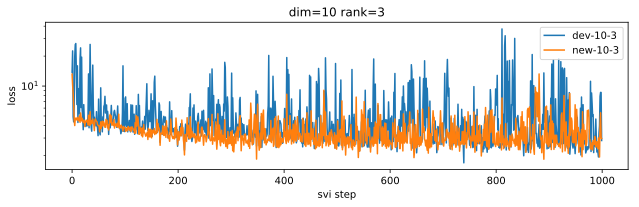

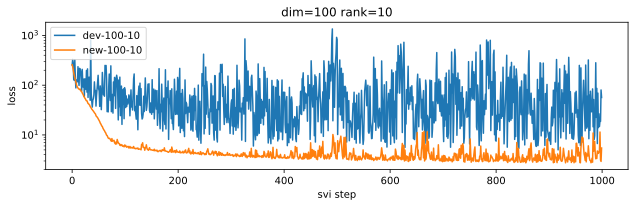

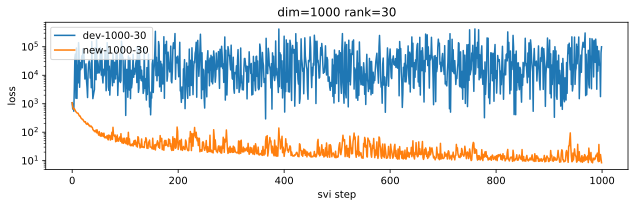

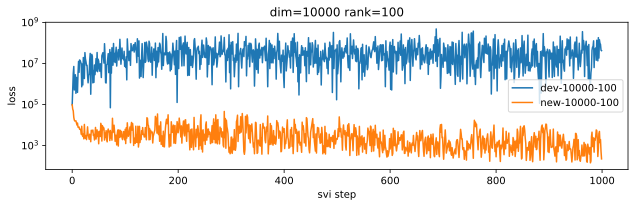

In [18]:
plot(10, 3)
plot(100, 10)
plot(1000, 30)
plot(10000, 100)